In [1]:
# !pip install -q opendatasets
!pip install -q torchsummary

In [1]:
# import opendatasets as od

# url = 'https://www.kaggle.com/hereisburak/pins-face-recognition'
# od.download(url)

In [2]:
import os

main_folder = './data/'

listdir = sorted(os.listdir(main_folder))

# for folder in listdir:
#     new_name = folder.split('_')[-1]
#     new_name = new_name.replace(" ", "_")

#     os.rename(main_folder + folder, main_folder + new_name)

In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

In [4]:
# stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
size = 224
batch_size=64
channels = 3

transformer = T.Compose([
    T.Resize(size), 
    T.CenterCrop(size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [5]:
dataset = ImageFolder(main_folder, transform=transformer)
classes = dataset.classes

len(dataset), dataset[0][0].size()

(603, torch.Size([3, 224, 224]))

In [6]:
def denormal(image):
    image = image.numpy().transpose(1, 2, 0)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
#     mean = (0.5,)
#     std = (0.5,)
    
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def denormalize(x, mean=stats[0], std=stats[1]):
    # 3, H, W, B
    ten = x.clone().permute(1, 2, 3, 0)
    for t, m, s in zip(ten, mean, std):
        t.mul_(s).add_(m)
    # B, 3, H, W
    return torch.clamp(ten, 0, 1).permute(3, 0, 1, 2)

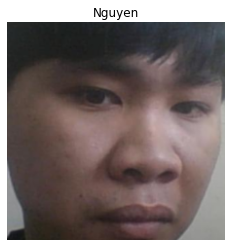

In [12]:
idx =  -500
img, lbl = dataset[idx]

plt.imshow(denormal(img))
plt.title(dataset.classes[lbl])
plt.axis('off');

In [13]:
torch.manual_seed(42)

num_val = int(len(dataset) * 0.1)

dataset, val_ds = random_split(dataset, [len(dataset) - num_val, num_val])

In [14]:
dl = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=3)


In [15]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

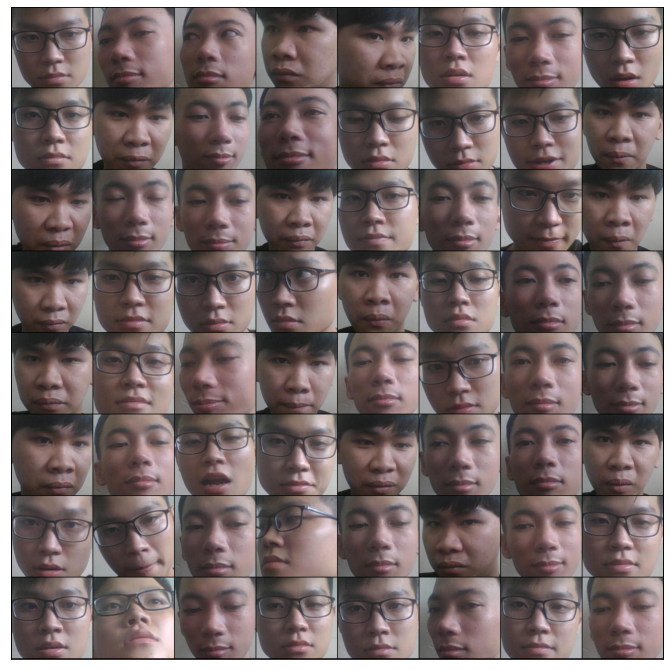

In [16]:
show_batch(dl)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from glob import glob
from tqdm.notebook import tqdm

In [19]:
# class FaceRecog(nn.Module):
#     def __init__(self, num_classes, pretrained=True):
#         super().__init__()
#         # Use a pretrained model
#         self.network = models.mobilenet_v2(pretrained=True)
#         # Replace last layer
#         self.network.classifier[1] = nn.Linear(self.network.classifier[1].in_features, num_classes)

#     def forward(self, xb):
#         return self.network(xb)
    
#     def summery(self, input_size):
#         return summary(self, input_size)
    

# class FaceRecog(nn.Module):
#     def __init__(self, num_classes, pretrained=True):
#         super().__init__()
#         # Use a pretrained model
#         self.network = models.resnet34(pretrained=pretrained)
#         # Replace last layer
#         self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

#     def forward(self, xb):
#         return self.network(xb)
    
#     def summery(self, input_size):
#         return summary(self, input_size)

class FaceRecog(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.resnet34 = models.resnet34(True)
        self.features = nn.Sequential(*list(self.resnet34.children())[:-1])
        # Replace last layer
        self.classifier = nn.Sequential(nn.Flatten(),
                                         nn.Linear(self.resnet34.fc.in_features, num_classes))

    def forward(self, x):
        x = self.features(x)
        y = self.classifier(x)
        return y
    
    def summary(self, input_size):
        return summary(self, input_size)


In [20]:
model = FaceRecog(num_classes=len(classes)).to(device)
model.summary((3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
       BatchNorm2d-4         [-1, 64, 112, 112]             128
              ReLU-5         [-1, 64, 112, 112]               0
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
             ReLU-14           [-1, 64,

In [22]:
learning_rate = 1e-4
n_epochs = 1

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
def train(epoch, n_epochs, model, dl, loss_func, device, optimizer, ds=dataset):
    model.train(True)
    torch.set_grad_enabled(True)
    
    epoch_loss = 0.0
    epochs_acc = 0
    
    tq_batch = tqdm(dl, total=len(dl))
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outs = model(images)
        _, preds = torch.max(outs, 1)
        
        loss = loss_func(outs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        
        tq_batch.set_description(f'Epoch [{epoch + 1}/{n_epochs}]')
        tq_batch.set_postfix_str('loss = {:.4f}'.format(loss.item()))

            
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [25]:
def evaluate(model, dl, loss_func, device, ds=val_ds):

    model.train(False)

    epoch_loss = 0
    epochs_acc = 0
    tq_batch = tqdm(dl, total=len(dl), leave=False)
    for images, labels in tq_batch:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = loss_func(outputs, labels)

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        tq_batch.set_description(f'Evaluate Model')
        
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [26]:
def fit(n_epochs, model, train_dataloader, valid_dataloader, loss_func, device, optimizer):
    
    history = []
    val_loss_ref = float('inf')
    patient = 5
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        loss, acc = train(epoch, n_epochs, model, train_dataloader, loss_func, device, optimizer)
        
        torch.cuda.empty_cache()
        val_loss, val_acc = evaluate(model, valid_dataloader, loss_func, device)
        
        history.append({'loss': loss, 'acc': acc, 'val_loss': val_loss, 'val_acc': val_acc})

        statement = "[loss]={:.4f} - [acc]={:.4f} - \
[val_loss]={:.4f} - [val_acc]={:.4f}".format(loss, acc, val_loss, val_acc,)
        print(statement)
        ####### Checkpoint
        if val_loss < val_loss_ref:
            patient = 5
            val_loss_ref = val_loss
            model_path = './demo.pth'
            torch.save(model.state_dict(), model_path)
            print(f"[INFO] Saving model dict, Epoch={epoch + 1}")
        else:
            if patient == 0: 
                break
            print(f"[INFO] {patient} lives left!")
            patient -= 1
            

    return history

In [27]:
res = fit(n_epochs, model, dl, val_dl, criterion, device, optimizer)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[loss]=0.2533 - [acc]=0.8987 - [val_loss]=0.0156 - [val_acc]=1.0000
[INFO] Saving model dict, Epoch=1


In [28]:
def show_results(history):
    accuracy = [res['acc'] for res in history]
    losses = [res['loss'] for res in history]
    val_accuracy = [res['val_acc'] for res in history]
    val_losses = [res['val_loss'] for res in history]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.plot(losses, '-o', label = 'Loss')
    ax1.plot(val_losses, '-o', label = 'Validation Loss')
    ax1.legend()

    ax2.plot(100 * np.array(accuracy), '-o', label = 'Accuracy')
    ax2.plot(100 * np.array(val_accuracy), '-o', label = 'Validation Accuracy')
    ax2.legend();
    
    fig.show()

c:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


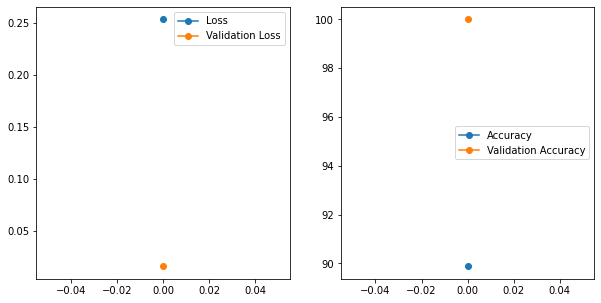

In [29]:
show_results(res)

In [30]:
y_test, y_pred = [], []
for imgs, lbls in tqdm(val_dl):
    imgs = imgs.to(device)
    outs = model(imgs)
    _, preds = torch.max(outs, dim = 1)
    y_test += lbls.tolist()
    y_pred += preds.tolist()

  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
loss, acc = evaluate(model, val_dl, criterion, device)
print(f'loss: {loss} - acc: {acc}')

  0%|          | 0/1 [00:00<?, ?it/s]

loss: 0.01561162993311882 - acc: 1.0


In [32]:
from termcolor import colored


for i, name in enumerate(classes):
    name = name.split("_")[-1]
    classes[i] = name

# classes

Nguyen
Nguyen
Phat
Phat
Phat
Quang
Quang
Phat
Quang
Phat
Nguyen
Quang
Nguyen
Nguyen
Quang
Quang


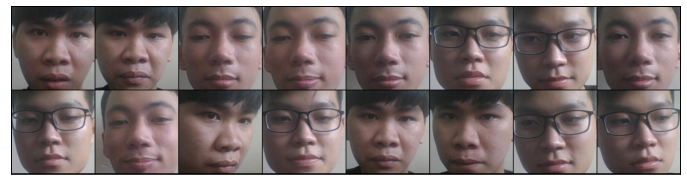

In [33]:
idx = 16
for imgs, lbls in val_dl:
    imgs = imgs.to(device)
    outs = model(imgs)
    _, preds = torch.max(outs, dim = 1)
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(imgs.cpu())
    ax.imshow(make_grid(denorm_images[:idx], nrow=8).permute(1, 2, 0).clamp(0,1))
    for p, lbl in zip(preds[:idx], lbls[:idx]):
        if lbl == p.cpu():
            print(colored(classes[p], 'green'))
        else:
            print(colored(classes[p], 'red'), colored(classes[lbl], 'blue'))
    break

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

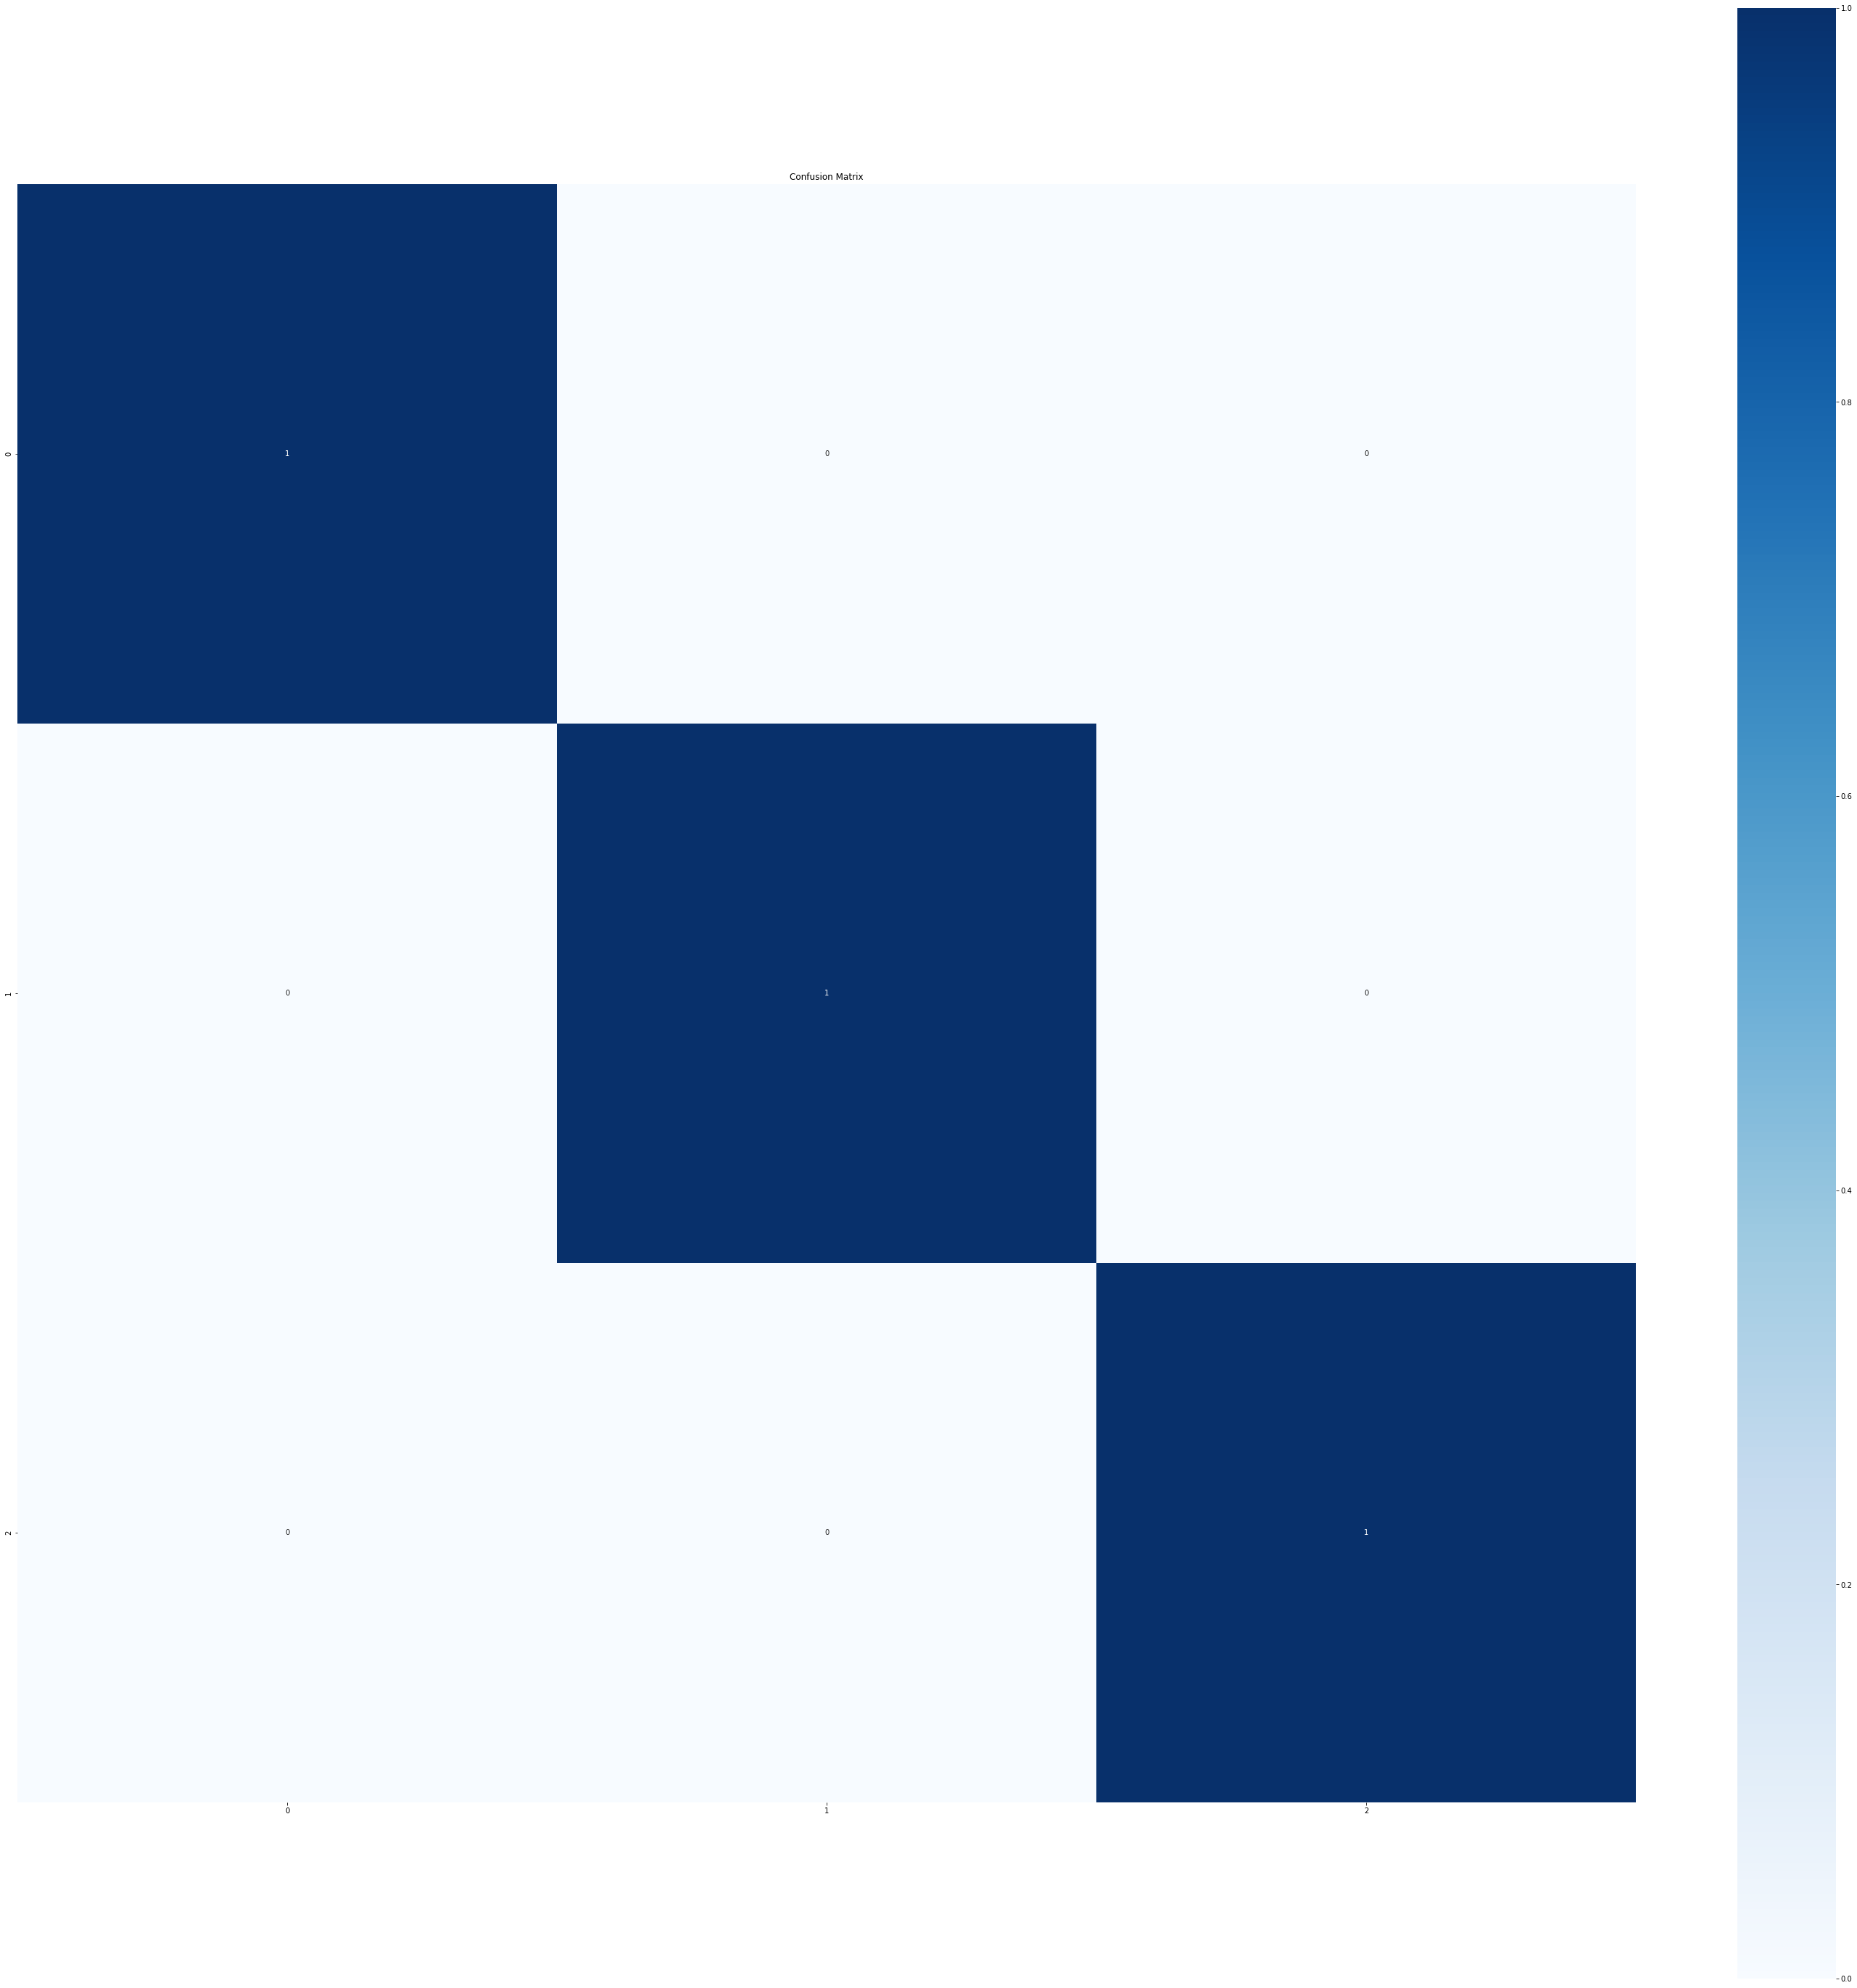

In [35]:
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(50, 50))
plt.title('Confusion Matrix')
sns.heatmap(cm_df, annot=True, cmap='Blues', square=True);

In [36]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        17

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

